# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Install Package with Country Codes

In [156]:
%pip install iso3166


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Upgrade Plotly

Run the cell below if you are working with Google Colab.

### Import Statements

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These might be helpful:
import plotly.express as px
from pprint import pprint
from iso3166 import countries
from datetime import datetime, timedelta
import iso3166
import random

### Notebook Presentation

In [158]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [159]:
df_data = pd.read_csv('mission_launches.csv')

# Preliminary Data Exploration

* What is the shape of `df_data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [160]:
print(f"Shape of data = {df_data.shape}")
print(f"Rows = {len(df_data)}, Columns = {len(df_data.columns)}")
print(f"Column names = {[colname for colname in list(df_data.columns) if 'Unnamed' not in colname]}")
nans = df_data.isnull()
dups_false = df_data.duplicated().value_counts(False)
if dups_false.item()==len(df_data) or nans:
    print("We have NaNs and/or duplicates")

Shape of data = (4324, 9)
Rows = 4324, Columns = 9
Column names = ['Organisation', 'Location', 'Date', 'Detail', 'Rocket_Status', 'Price', 'Mission_Status']
We have NaNs and/or duplicates


## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data. 

In [161]:
df_data = df_data.dropna()
df_data = df_data.drop_duplicates()

## Descriptive Statistics

# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

In [162]:
organization_names = list(set(df_data['Organisation'].values))
x = df_data.groupby('Organisation')
launches = [0] * len(organization_names)

for o in range(len(organization_names)):
    launches[o] = len(x.get_group(organization_names[o]))

Text(0.5, 1.0, 'Number of Launches Per Company')

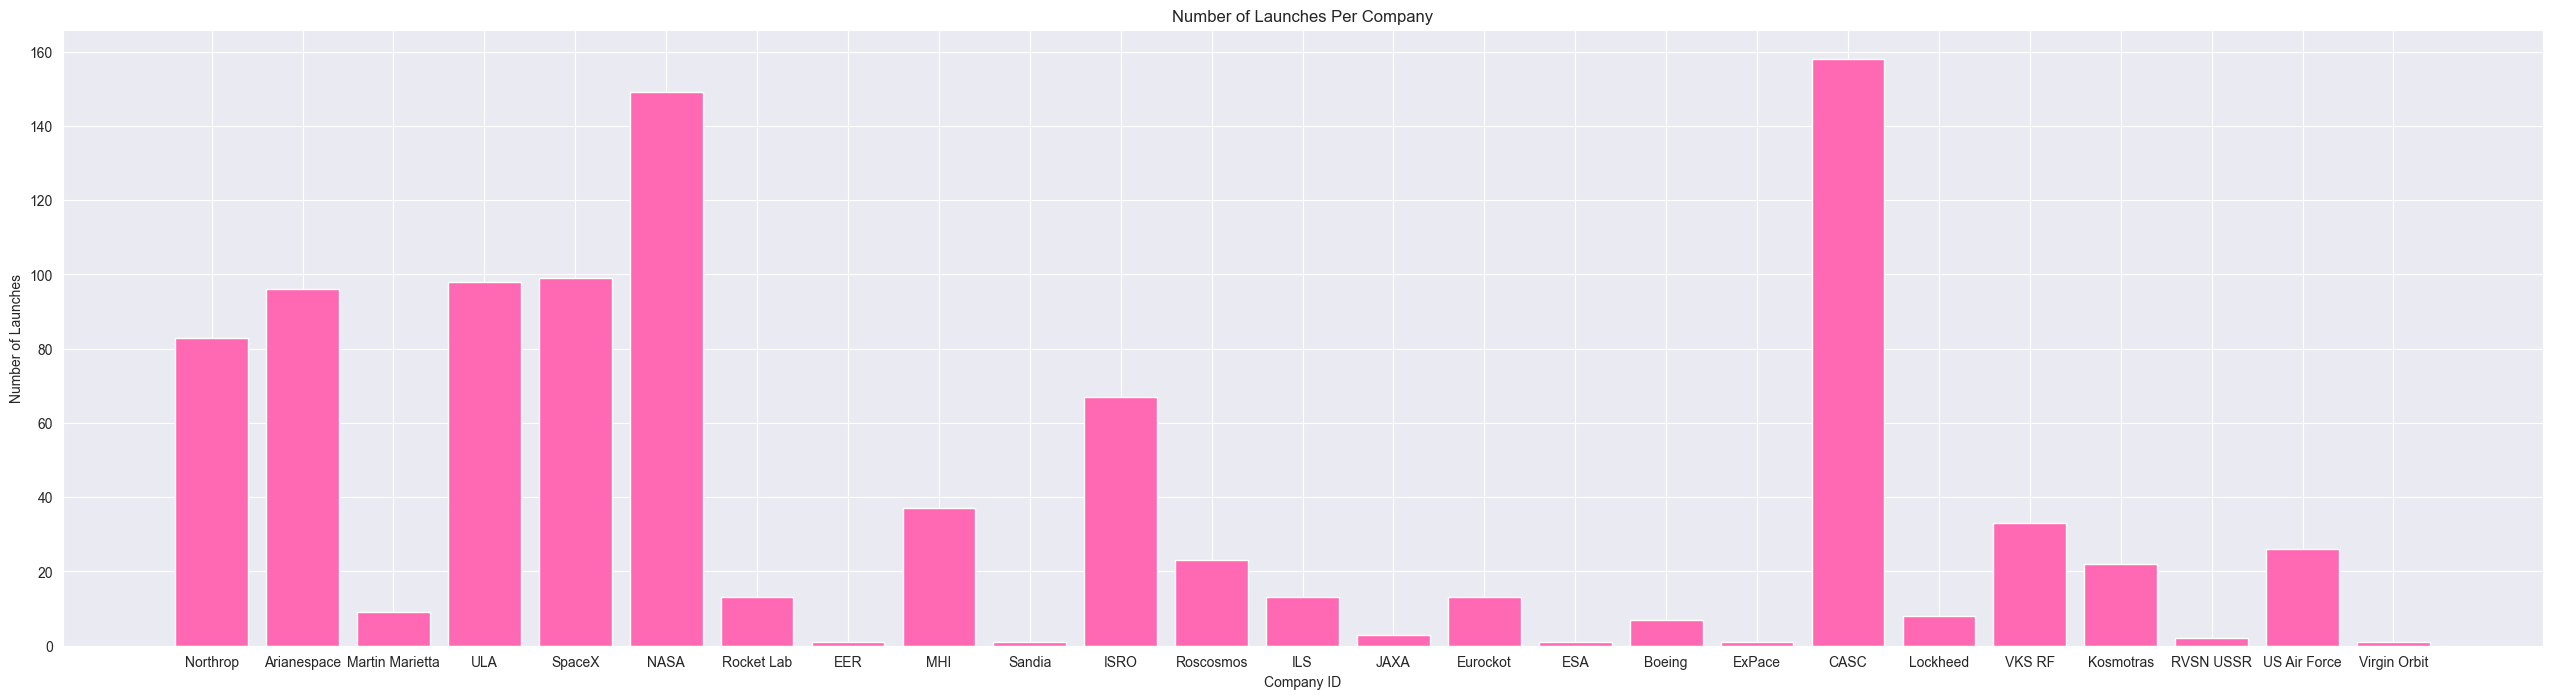

In [163]:
plt.figure(figsize=(32,8))
plt.bar(organization_names, launches, color='hotpink')
plt.xlabel("Company ID")
plt.ylabel("Number of Launches")
plt.title("Number of Launches Per Company")

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

In [164]:
rocket_statuses = df_data.groupby("Rocket_Status")
active_count = len(rocket_statuses.get_group('StatusActive'))
retired_count = len(df_data) - active_count
print(f"{active_count} rockets are active")
print(f"{retired_count} rockets are retired")

586 rockets are active
378 rockets are retired


# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [165]:
mission_statuses = df_data.groupby('Mission_Status')
success_count = len(mission_statuses.get_group("Success"))
failed_count = len(df_data) - success_count
print(f"{success_count} missions succeeded")
print(f"{failed_count} missions failed")

910 missions succeeded
54 missions failed


# How Expensive are the Launches? 

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values). 

In [166]:
prices = df_data['Price'].values
groups = ['[0,20)', '[20,40)', '[40,60)', '[60,80)', '[80,100)', '100+']
counts = [0, 0, 0, 0, 0, 0]
for price in prices:
    _price = float(price.replace(',',''))
    if 0 <= _price < 20:
        counts[0] += 1
    elif 20 <= _price < 40:
        counts[1] += 1
    elif 40 <= _price < 60:
        counts[2] += 1
    elif 60 <= _price < 80:
        counts[3] += 1
    elif 80 <= _price < 100:
        counts[4] += 1
    else:
        counts[5] += 1    

Text(0.5, 1.0, 'Number of Launches and their Prices')

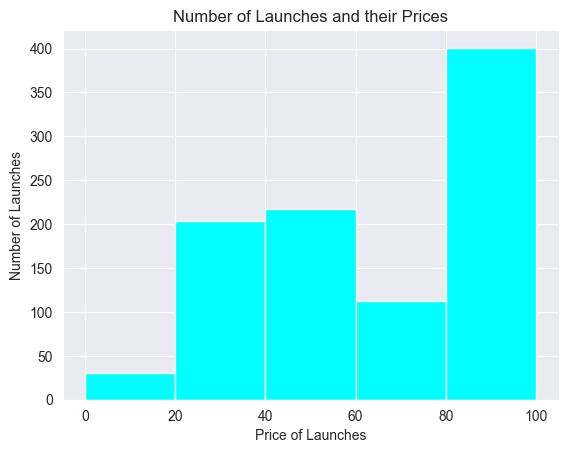

In [167]:
plt.figure()
plt.hist(x=[0, 20, 40, 60, 80, 100], bins=[0, 20, 40, 60, 80, 100], weights=counts, color='cyan')
plt.xlabel("Price of Launches")
plt.ylabel("Number of Launches")
plt.title("Number of Launches and their Prices")

# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map. 
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [168]:
df_data_copy = df_data.copy()
df_data_copy = df_data_copy.dropna()
df_data_copy = df_data_copy.drop_duplicates()

def edit_country_name(country):
    if country in ['Russia', 'Barents Sea']:
        return 'RUSSIAN FEDERATION'
    elif country in ['New Mexico', 'Pacific Missile Range Facility', 'Gran Canaria', 'USA']:
        return 'UNITED STATES OF AMERICA'
    elif country == 'Yellow Sea':
        return 'CHINA'
    elif country == 'Shahrud Missile Test Site':
        return 'IRAN'
    
    return country.upper()

COUNTRIES_ALPHA3 = []

for ddc in range(len(df_data_copy)):
    country_name = edit_country_name(df_data_copy.iloc[ddc]['Location'].split(', ')[-1])
    for alpha3code in list(iso3166.countries_by_alpha3.keys()):
        if iso3166.countries_by_alpha3[alpha3code].name.upper() == country_name:
            COUNTRIES_ALPHA3.append(alpha3code)
            break

df_data_copy['Location'] = COUNTRIES_ALPHA3

In [169]:
country_groups = df_data_copy.groupby('Location').count()
unique_countries = list(country_groups.index)
launches_per_country = [0] * len(unique_countries)

for c in range(len(unique_countries)):
    launches_per_country[c] = len(df_data_copy[df_data_copy['Location']==unique_countries[c]])

px.choropleth(locations=unique_countries, color=launches_per_country)

# Use a Choropleth Map to Show the Number of Failures by Country


In [170]:
country_groups = df_data_copy.groupby('Location').count()
unique_countries = list(country_groups.index)
failures_per_country = [0] * len(unique_countries)

for c in range(len(unique_countries)):
    x = df_data_copy[(df_data_copy['Location'] == unique_countries[c]) & (df_data_copy['Mission_Status'] == 'Failure')]
    failures_per_country[c] = len(x)

px.choropleth(locations=unique_countries, color=failures_per_country)

# Create a Plotly Sunburst Chart of the countries, organisations, and mission status. 

In [171]:
status = df_data_copy['Mission_Status'].values.tolist()

data = dict(
    country=df_data_copy['Location'].values.tolist(),
    organization=df_data_copy['Organisation'].values.tolist(),
    mission_statuses=[1 if stat == 'Success' else 0 for stat in status]
)

In [172]:
px.sunburst(data, parents='country', names='organization', values='mission_statuses')

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

In [175]:
organization_names = list(set(df_data['Organisation'].values))
spendings = df_data.groupby('Organisation')

total_spent = [0] * len(organization_names)

for i in range(len(organization_names)):
    prices = spendings.get_group(organization_names[i])['Price'].values
    total = sum([float(p.replace(',','')) for p in prices])
    total_spent[i] = total
    

Text(0.5, 0, 'Organization')

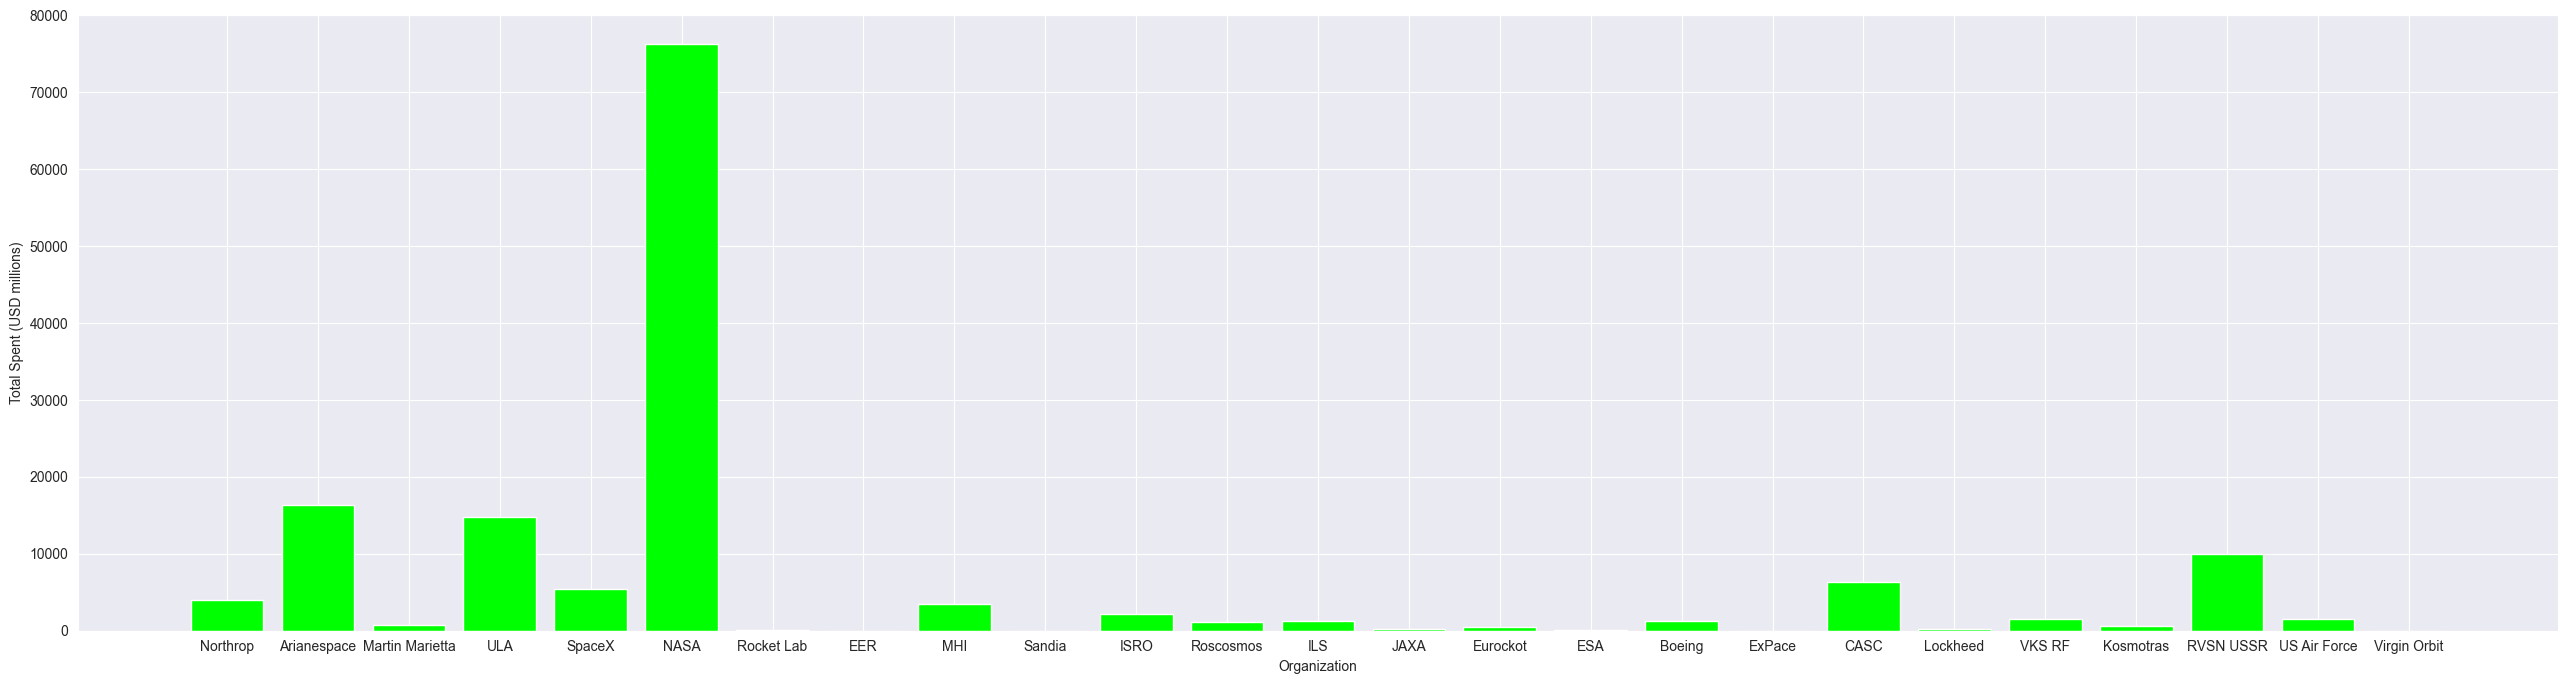

In [176]:
plt.figure(figsize=(32,8))
plt.bar(organization_names, total_spent, color='lime')
plt.ylabel("Total Spent (USD millions)")
plt.xlabel("Organization")

# Analyse the Amount of Money Spent by Organisation per Launch

In [177]:
hex_chars = [0,1,2,3,4,5,6,7,8,9,'a','b','c','d','e','f']
def random_color():
    color = '#'
    for _ in range(6):
        color += str(random.choice(hex_chars))
    return color

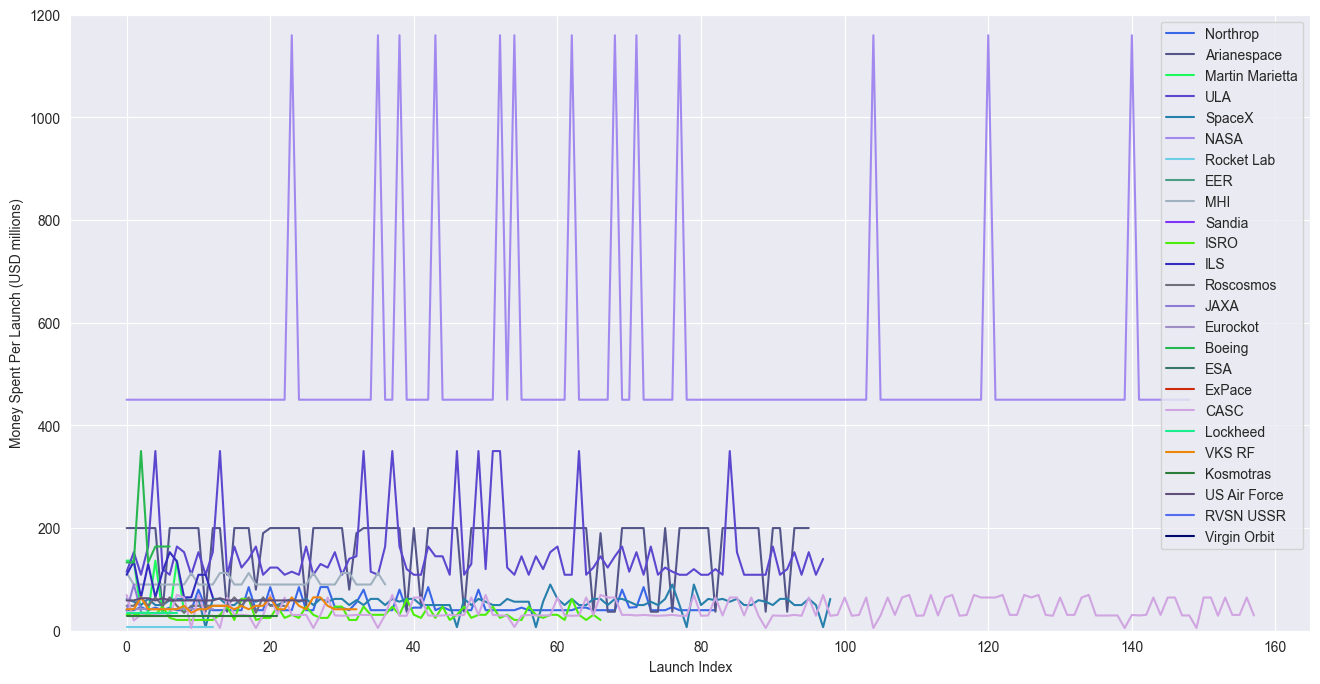

In [179]:
df_data = df_data.sort_values(by=['Date'])
organization_names = list(set(df_data['Organisation'].values))
organization_groups = df_data.groupby('Organisation')

plt.figure(figsize=(16,8))
plt.ylabel('Money Spent Per Launch (USD millions)')
plt.ylim(0,1200)
plt.xlabel("Launch Index")

for i in range(len(organization_names)):
    launch_indexes = list(range(len(organization_groups.get_group(organization_names[i]))))
    _x = organization_groups.get_group(organization_names[i])['Price'].values
    launch_spendings = [float(s.replace(',','')) for s in _x]
    plt.plot(launch_indexes, launch_spendings, color=random_color(), label=organization_names[i])

plt.legend()

# Chart the Number of Launches per Year

In [180]:
df_data = pd.read_csv('mission_launches.csv')
dates = df_data['Date'].values
years = [int(date.split(' ')[3]) for date in dates]
df_data['Date'] = years

In [181]:
years_group = df_data.groupby('Date')
unique_years = list(set(years))
year_counts = [len(years_group.get_group(year)) for year in unique_years]    

<BarContainer object of 64 artists>

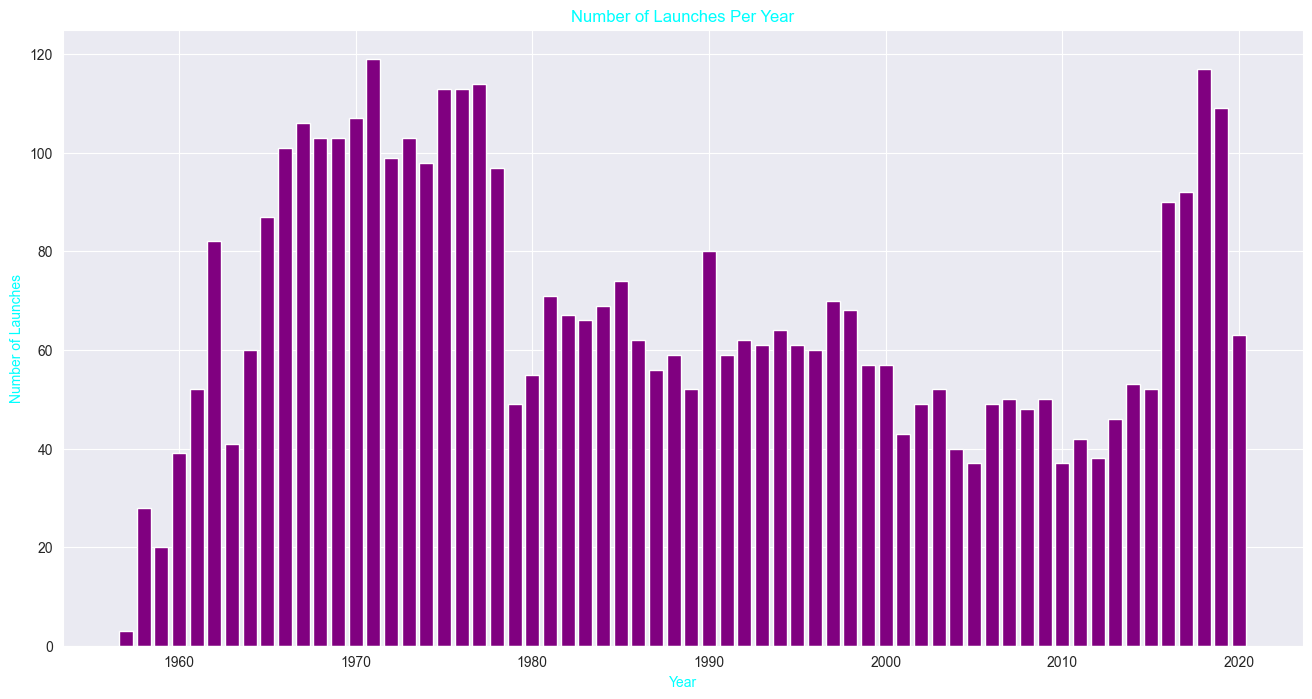

In [182]:
plt.figure(figsize=(16,8))
plt.title("Number of Launches Per Year", color='cyan')
plt.xlabel("Year", color='cyan')
plt.ylabel("Number of Launches", color='cyan')
plt.bar(unique_years, year_counts, color='purple')

# Chart the Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart. 

In [183]:
df_data = pd.read_csv('mission_launches.csv')
dates = df_data['Date'].values
months = [f"{date.split(' ')[1]}" for date in dates]
df_data['Date'] = months

In [185]:
month_group = df_data.groupby('Date')
unique_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = [len(month_group.get_group(month)) for month in unique_months]

<BarContainer object of 12 artists>

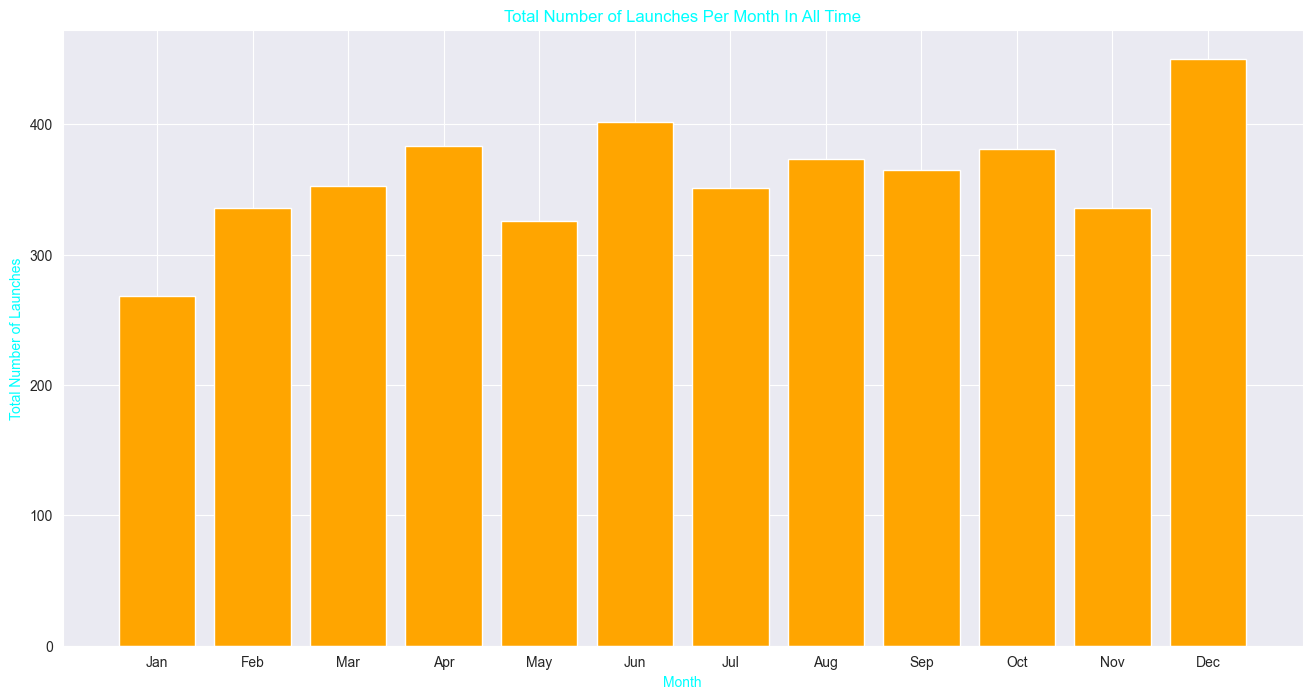

In [186]:
plt.figure(figsize=(16,8))
plt.title("Total Number of Launches Per Month In All Time", color='cyan')
plt.xlabel("Month", color='cyan')
plt.ylabel("Total Number of Launches", color='cyan')
plt.bar(unique_months, month_counts, color='orange')

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

In [194]:
x = month_group.count().sort_values(by=['Unnamed: 0'])
_min = x[x['Unnamed: 0']==x.iloc[0]['Unnamed: 0']]
_max = x[x['Unnamed: 0']==x.iloc[len(x)-1]['Unnamed: 0']]
print(f"{_min.index.item()} is the least popular")
print(f"{_max.index.item()} is the most popular")

Jan is the least popular
Dec is the most popular


# How has the Launch Price varied Over Time? 

Create a line chart that shows the average price of rocket launches over time. 

In [195]:
# see chart generated in 'Analyse the Amount of Money Spent by Organisation per Launch'

# Chart the Number of Launches over Time by the Top 10 Organisations. 

How has the dominance of launches changed over time between the different players? 

In [223]:
months = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

def convert_to_ymd(original_format):
    splitted = original_format.split(' ')
    month = str(months[ splitted[1] ]).zfill(2)
    day = str(splitted[2][:-1]).zfill(2)
    year = splitted[3]
    return f"{year}-{month}-{day}"

Text(0, 0.5, 'Number of Launches')

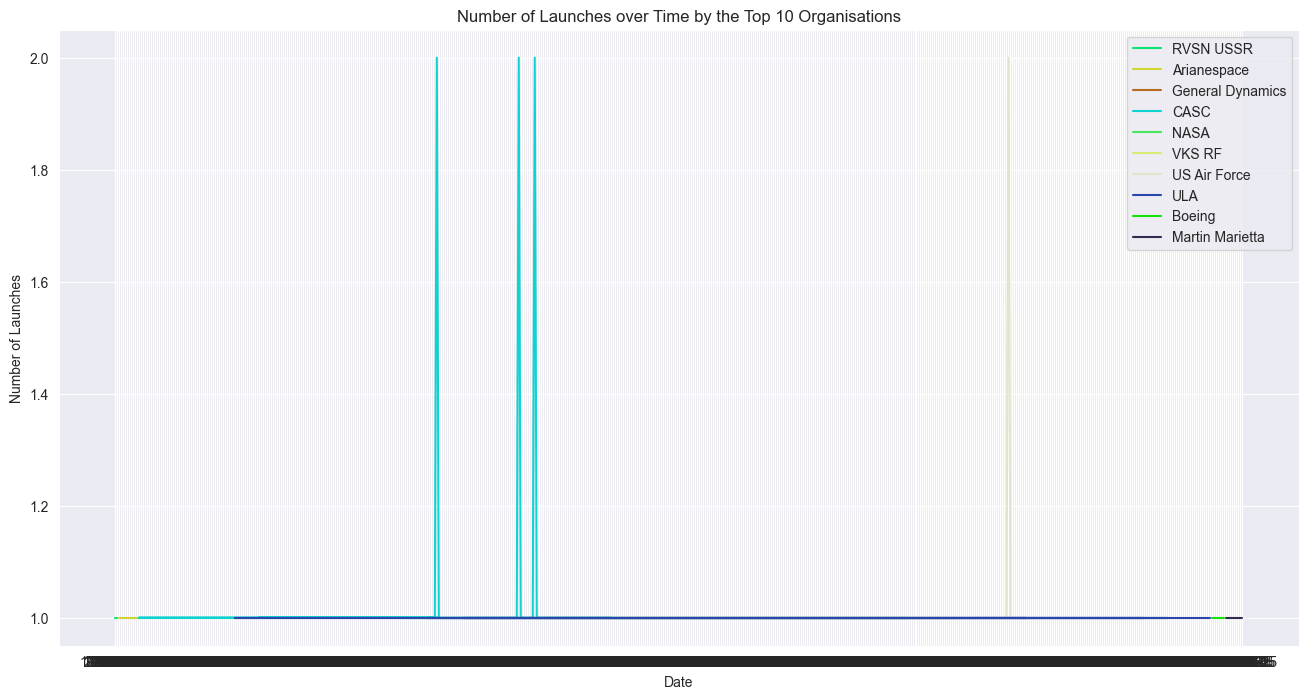

In [248]:
df_data_copy = df_data.copy()
df_data_copy = df_data_copy.dropna()
df_data_copy = df_data_copy.drop_duplicates()

top10_organizations = df_data.groupby('Organisation').count().sort_values(by=['Unnamed: 0'], ascending=False)[:10]
top10_organizations = top10_organizations.index.tolist()

dates_ymd = [convert_to_ymd(date) for date in df_data_copy.Date.values]

df_data_copy['Date'] = dates_ymd
df_data_copy = df_data_copy.sort_values(by='Date', ascending=True)

plt.figure(figsize=(16,8))
for o in range(len(top10_organizations)):
    org_name = top10_organizations[o]
    org_launches = df_data_copy[df_data_copy['Organisation']==org_name]
    
    date_groups = org_launches.groupby('Date').count().index.tolist()
    launches = [count[0] for count in org_launches.groupby('Date').count().values.tolist()]
    plt.plot(date_groups, launches, label=org_name, color=random_color())    

plt.legend()
plt.title("Number of Launches over Time by the Top 10 Organisations")
plt.xlabel("Date")
plt.ylabel("Number of Launches")

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. 

In [306]:
df_data_copy = df_data.copy().dropna().drop_duplicates()

# convert dates to years only
_dates = df_data_copy['Date'].values.tolist()
_years = [ int(date.split(' ')[3]) for date in _dates ]
df_data_copy['Date'] = _years

# convert locations to countries alone
_locations = df_data_copy['Location'].values.tolist()
_countries = [loc.split(' ')[-1] for loc in _locations]
df_data_copy['Location'] = _countries

df_data_cold_war = df_data_copy[df_data_copy['Date']<=1991]
df_data_cold_war = df_data_cold_war[
    (df_data_copy['Location']=='USA') | 
    (df_data_copy['Location']=='Russia') | 
    (df_data_copy['Location']=='Kazakhstan')
]

/var/folders/hh/_2x0r4k109x_pxv75wjltqt40000gn/T/ipykernel_2422/107811290.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

Hint: Remember to include former Soviet Republics like Kazakhstan when analysing the total number of launches. 

([<matplotlib.patches.Wedge at 0x2bb840f10>,
 [Text(1.0974356460141006, 0.07506665609718889, 'Northrop'),
  Text(-0.5391211554665737, 0.9588265639459446, 'NASA'),
  Text(0.22380139789077624, -1.0769925414329176, 'US Air Force'),
  Text(1.0089323334266223, -0.4382414249775019, 'RVSN USSR'),
  Text(1.0840054267875872, -0.18690167119386872, 'Martin Marietta')])

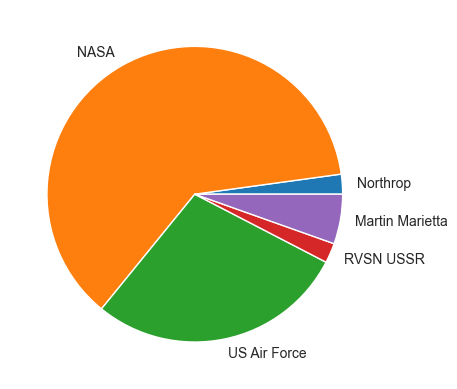

In [307]:
organization_names = list(set(df_data_cold_war['Organisation'].values))
launch_counts = []
for org in organization_names:
    launch_counts.append( len(df_data_cold_war.groupby('Organisation').get_group(org)) )
plt.pie(launch_counts, labels=organization_names)

## Create a Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

In [314]:
_sorted_years = list(set(sorted(_years)))
usa_total_launches = [0] * len(_sorted_years)
soviet_total_launches = [0] * len(_sorted_years)

for y in range(len(_sorted_years)):
    _year = _sorted_years[y]
    this_year = df_data_cold_war[df_data_cold_war['Date'] == _year]
    
    usa_launches_this_year = len(this_year[(this_year['Location'] == 'USA')])
    soviet_launches_this_year = len(this_year) - usa_launches_this_year
    
    usa_total_launches[y] = usa_launches_this_year
    soviet_total_launches[y] = soviet_launches_this_year    

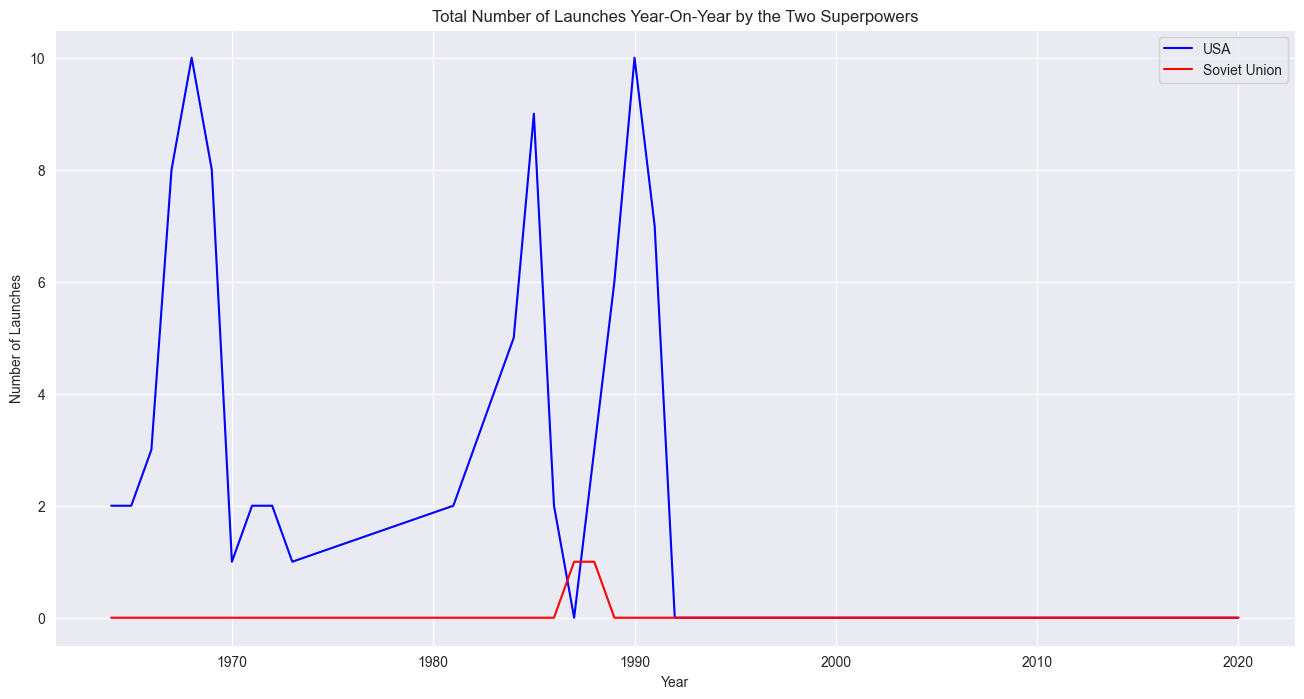

In [315]:
plt.figure(figsize=(16,8))
plt.plot(_sorted_years, usa_total_launches, color='blue', label='USA')
plt.plot(_sorted_years, soviet_total_launches, color='red', label='Soviet Union')
plt.xlabel("Year")
plt.ylabel("Number of Launches")
plt.title("Total Number of Launches Year-On-Year by the Two Superpowers")
plt.legend()

## Chart the Total Number of Mission Failures Year on Year.

Text(0.5, 1.0, 'Total Number of Mission Failures Year on Year')

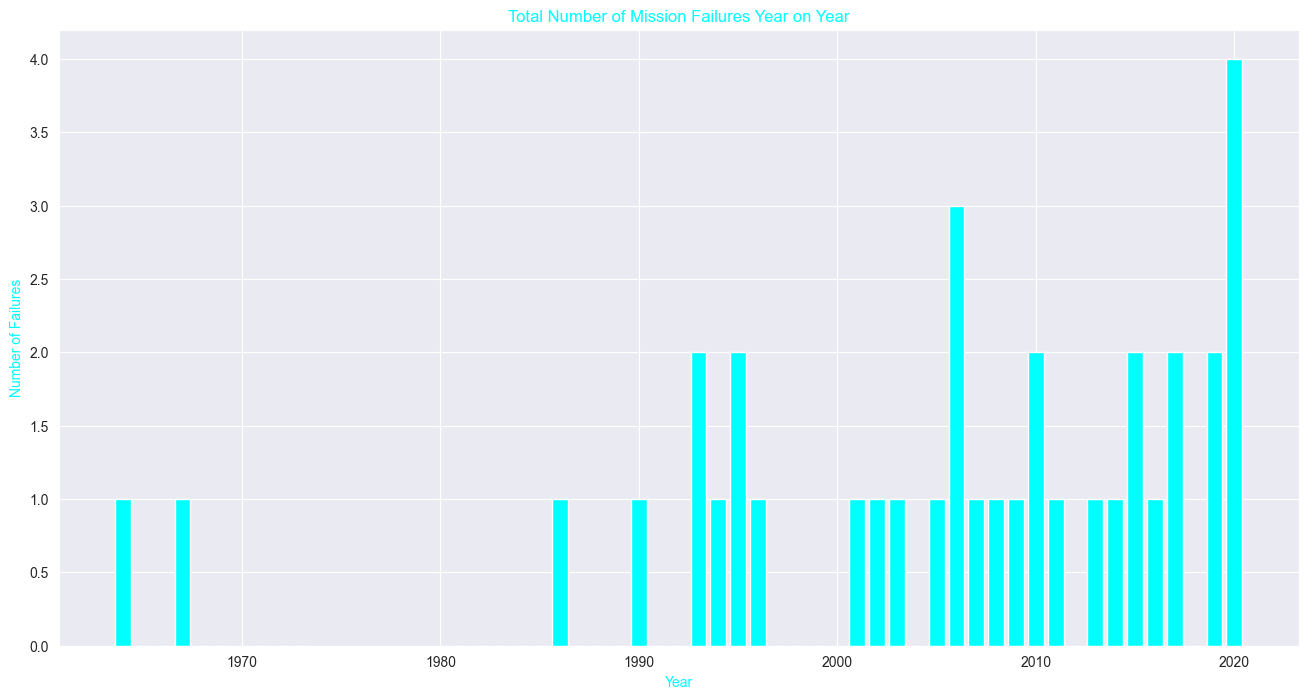

In [316]:
df_data_copy = df_data.copy().dropna().drop_duplicates()
_dates = df_data_copy['Date'].values.tolist()
_years = [ int(date.split(' ')[3]) for date in _dates ]
df_data_copy['Date'] = _years

_sorted_years = list(set(sorted(_years)))
_failures_per_year = [0] * len(_sorted_years)

for y in range(len(_sorted_years)):
    _failures_per_year[y] = len(df_data_copy[(df_data_copy['Date']==_sorted_years[y]) & (df_data_copy['Mission_Status']=='Failure')])

plt.figure(figsize=(16,8))
plt.bar(_sorted_years, _failures_per_year, color='cyan')
plt.xlabel("Year", color='cyan')
plt.ylabel("Number of Failures", color='cyan')
plt.title("Total Number of Mission Failures Year on Year", color='cyan')

## Chart the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time? 

Text(0.5, 1.0, 'Percentage of Total Mission Failures Year on Year')

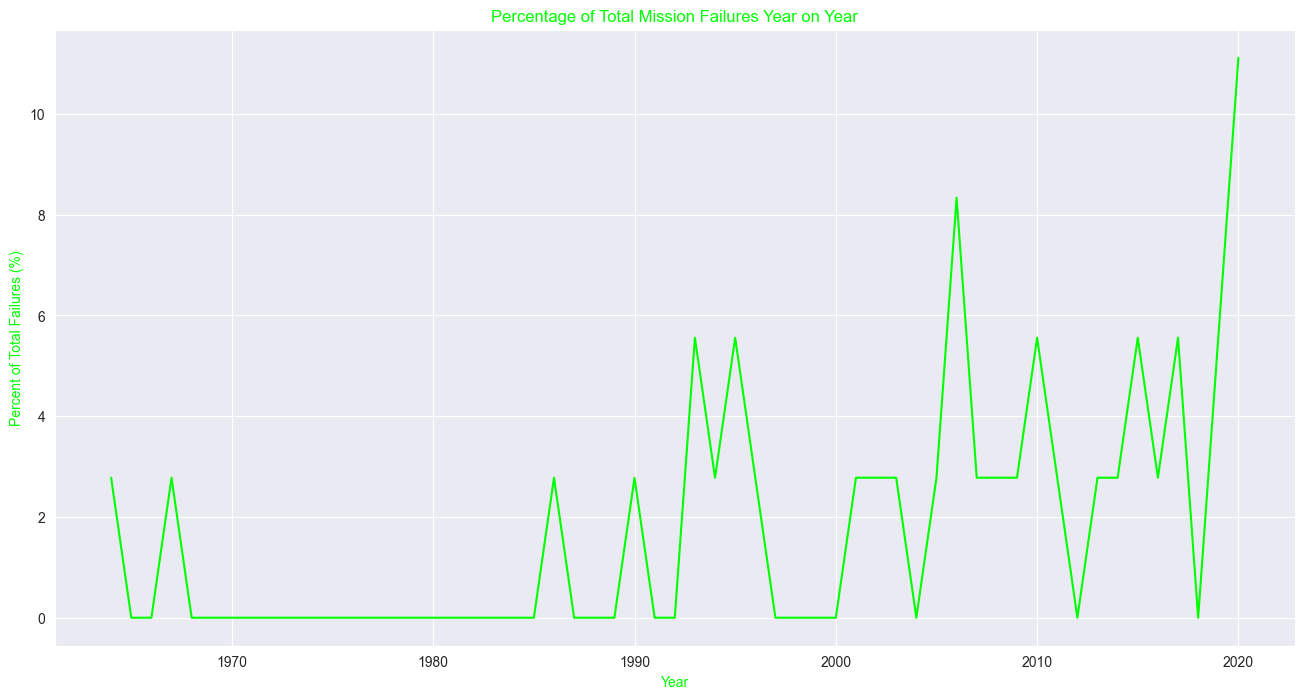

In [317]:
total_failure_count = sum(_failures_per_year)
plt.figure(figsize=(16,8))
plt.plot(_sorted_years, [(fpy/total_failure_count)*100 for fpy in _failures_per_year], color='lime')
plt.xlabel("Year", color='lime')
plt.ylabel("Percent of Total Failures (%)", color='lime')
plt.title("Percentage of Total Mission Failures Year on Year", color='lime')

# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches? 

In [318]:
df_data_copy = df_data.copy().dropna().drop_duplicates()
_dates = df_data_copy['Date'].values.tolist()
_years = [ int(date.split(' ')[3]) for date in _dates ]

_locations = df_data_copy['Location'].values.tolist()
_countries = [loc.split(' ')[-1] for loc in _locations]

df_data_copy['Date'] = _years
df_data_copy['Location'] = _countries

_sorted_years = list(set(sorted(_years)))

results = {}

for y in range(len(_sorted_years)):
    _year = _sorted_years[y]
    
    successful_launches_this_year = df_data_copy[(df_data_copy['Date']==_year) & (df_data_copy['Mission_Status']=='Success')]
    slty_org_groups = successful_launches_this_year.groupby('Organisation').count().sort_values(by='Location', ascending=False)
    
    all_launches_this_year = df_data_copy[(df_data_copy['Date']==_sorted_years[y])]
    alty_org_groups = all_launches_this_year.groupby('Organisation').count().sort_values(by='Location', ascending=False)
    
    results[str(_year)] = {
        'most_total_launches':alty_org_groups.index.tolist()[0], 
        'most_successful_launches':slty_org_groups.index.tolist()[0]
    }
    
pprint(results)

{'1964': {'most_successful_launches': 'US Air Force',
          'most_total_launches': 'US Air Force'},
 '1965': {'most_successful_launches': 'US Air Force',
          'most_total_launches': 'US Air Force'},
 '1966': {'most_successful_launches': 'US Air Force',
          'most_total_launches': 'US Air Force'},
 '1967': {'most_successful_launches': 'US Air Force',
          'most_total_launches': 'US Air Force'},
 '1968': {'most_successful_launches': 'US Air Force',
          'most_total_launches': 'US Air Force'},
 '1969': {'most_successful_launches': 'NASA', 'most_total_launches': 'NASA'},
 '1970': {'most_successful_launches': 'NASA', 'most_total_launches': 'NASA'},
 '1971': {'most_successful_launches': 'NASA', 'most_total_launches': 'NASA'},
 '1972': {'most_successful_launches': 'NASA', 'most_total_launches': 'NASA'},
 '1973': {'most_successful_launches': 'NASA', 'most_total_launches': 'NASA'},
 '1981': {'most_successful_launches': 'NASA', 'most_total_launches': 'NASA'},
 '1982': {'m

# Create a Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020? 

In [322]:
results_2018 = results['2018']
print(f"2018 - {results_2018}")
results_2019 = results['2019']
print(f"2019 - {results_2019}")
results_2020 = results['2020']
print(f"2020 - {results_2020}")

2018 - {'most_total_launches': 'CASC', 'most_successful_launches': 'CASC'}
2019 - {'most_total_launches': 'CASC', 'most_successful_launches': 'CASC'}
2020 - {'most_total_launches': 'CASC', 'most_successful_launches': 'CASC'}


In [326]:
years_70s = [year for year in results.keys() if 1970<=int(year)<=1979]
for y70 in years_70s:
    print(f"{y70} - {results[y70]}")

years_80s = [year for year in results.keys() if 1980<=int(year)<=1989]
for y80 in years_80s:
    print(f"{y80} - {results[y80]}")

1970 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1971 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1972 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1973 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1981 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1982 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1983 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1984 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1985 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1986 - {'most_total_launches': 'NASA', 'most_successful_launches': 'CASC'}
1987 - {'most_total_launches': 'CASC', 'most_successful_launches': 'CASC'}
1988 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
1989 - {'most_total_launches': 'NASA', 'most_successful_launches': 'NASA'}
